# ARIMA

# IMPORT LIBRARY

statsmodels: It provides classes and functions for estimating and testing statistical models. This includes linear and non-linear regression models, time series analysis, and various statistical tests.

pmdarima: This library is specifically designed for time series analysis and provides an implementation of the AutoRegressive Integrated Moving Average (ARIMA) model. It's built on top of statsmodels.

In [1]:
!pip install pmdarima
!pip install statsmodels
!pip install pyramid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.3/247.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 15.9 MB/s eta 0:00:00


In [2]:
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


import pyramid
import pmdarima
from pmdarima.arima import auto_arima

import warnings
# Filter out Arrow-related RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pyarrow")

# IMPORT DATA and PREPARE

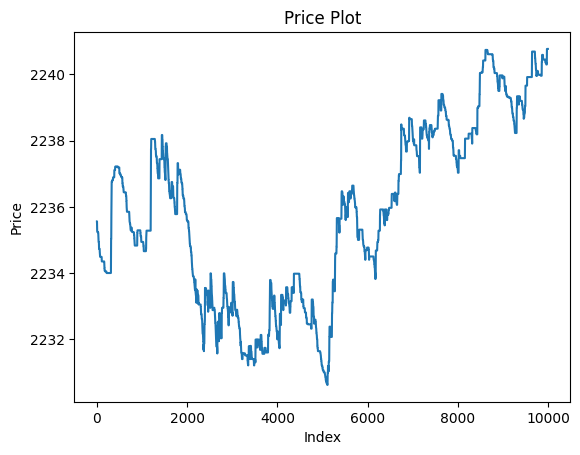

In [3]:
# path = "Path ที่นำทางไปสู่ไฟล์ Dataset ที่ต้องการ"
cols = ['id','price','qty','amount','period','bid','offer']
#path = "/content/ETHUSDT-trades-2024-01-04.csv"
#path = "/content/ETHUSDT-trades-2024-01-05.csv"
path = "/content/ETHUSDT-trades-2024-01-06.csv"
df = pd.read_csv(path, names=cols)

df['period'] = pd.to_datetime(df['period'], unit='ms', errors='coerce')
df = df[df['bid'] == True]
df = df[ ['id', 'price'] ]
df = df.tail(10000).reset_index(drop=True)

df
#Plot the 'price' column
plt.plot(df['price'])
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Price Plot')
plt.show()


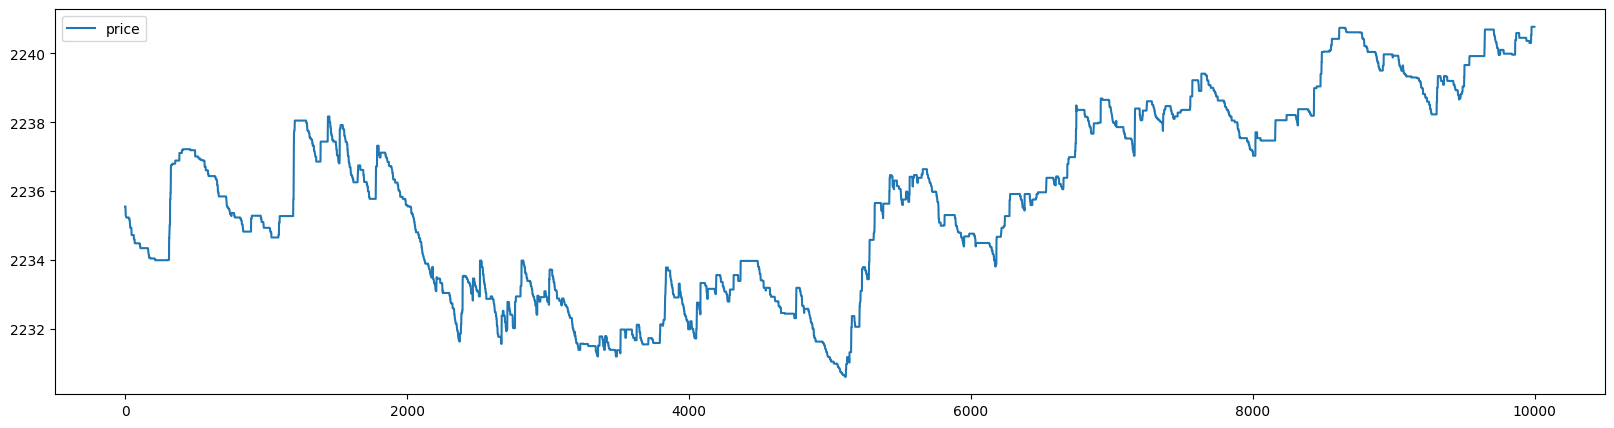

In [4]:
df['price'].plot(figsize = (20, 5), legend = True);

In [6]:
df = df.set_index('id')

# Stationary Test

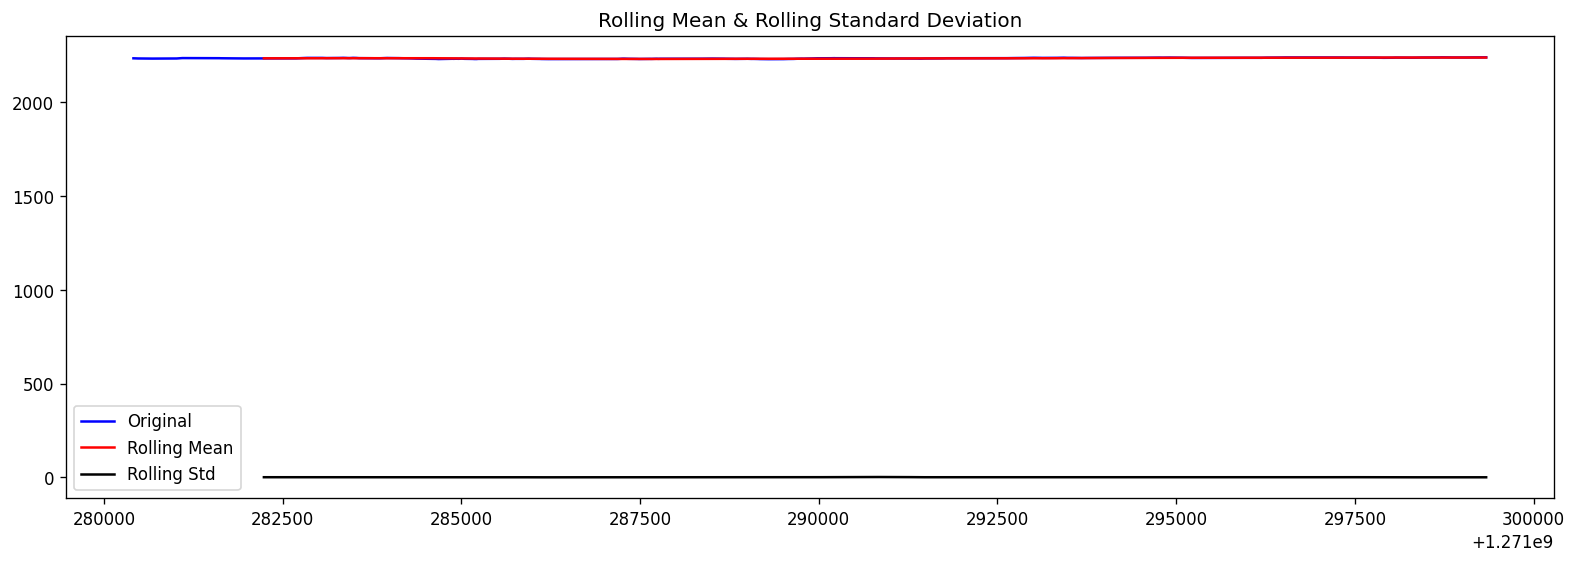

id
1271280414    2235.56
1271280415    2235.56
1271280416    2235.38
1271280417    2235.31
1271280418    2235.29
               ...   
1271299332    2240.77
1271299333    2240.77
1271299334    2240.77
1271299335    2240.77
1271299337    2240.77
Name: price, Length: 10000, dtype: float64

In [8]:
rolling_mean = df.price.rolling(window = 1000).mean()
rolling_std = df.price.rolling(window = 1000).std()
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

df.price

In [9]:
result = adfuller(df['price'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.0815754123544858
p-value: 0.7223632153581998
Critical Values:
	1%: -3.4310047528604803
	5%: -2.861829361784287
	10%: -2.5669240221402583


In [11]:
def get_stationarity(timeseries):

    # rolling statistics
    rolling_mean = timeseries.rolling(window=1000).mean()
    rolling_std = timeseries.rolling(window=1000).std()
    #rolling_mean = timeseries.rolling(window=12).mean()
    #rolling_std = timeseries.rolling(window=12).std()

    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey–Fuller test:
    result = adfuller(timeseries['price'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

# ลบด้วยค่าเฉลี่ยเคลื่อนที่

,price
id,
1271280414,7.712247
1271280415,7.712247
1271280416,7.712167
1271280417,7.712135
1271280418,7.712126
...,...
1271299332,7.714575
1271299333,7.714575
1271299334,7.714575


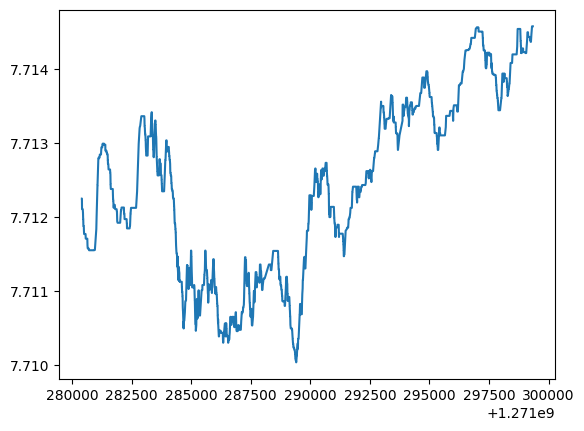

In [12]:
df_log = np.log(df)
plt.plot(df_log)

df_log

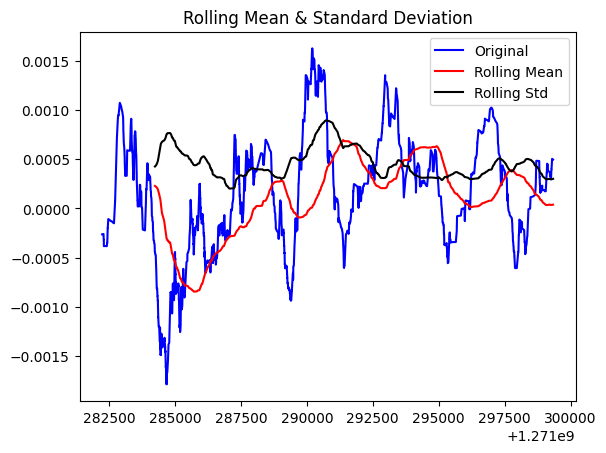

ADF Statistic: -3.0318585159883646
p-value: 0.03202443753955612
Critical Values:
	1%: -3.4310775239640425
	5%: -2.8618615183417497
	10%: -2.5669411391862456


,price
id,
1271282239,-0.000263
1271282241,-0.000263
1271282242,-0.000263
1271282251,-0.000263
1271282252,-0.000262
...,...
1271299332,0.000497
1271299333,0.000497
1271299334,0.000496


In [13]:
rolling_mean = df_log.rolling(window=1000).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

df_log_minus_mean

อย่างที่เราเห็นหลังจากลบค่าเฉลี่ยค่าเฉลี่ยเคลื่อนที่และส่วนเบี่ยงเบนมาตรฐานจะเป็นแนวนอนโดยประมาณ ค่า p ต่ำกว่าเกณฑ์ 0.05 และสถิติ ADF ใกล้เคียงกับค่าวิกฤต ดังนั้นอนุกรมเวลาจึงเป็น stationaryการใช้การสลายตัวแบบเลขชี้กำลังเป็นอีกวิธีหนึ่งในการแปลงอนุกรมเวลาให้เป็นแบบคงที่

# take_log

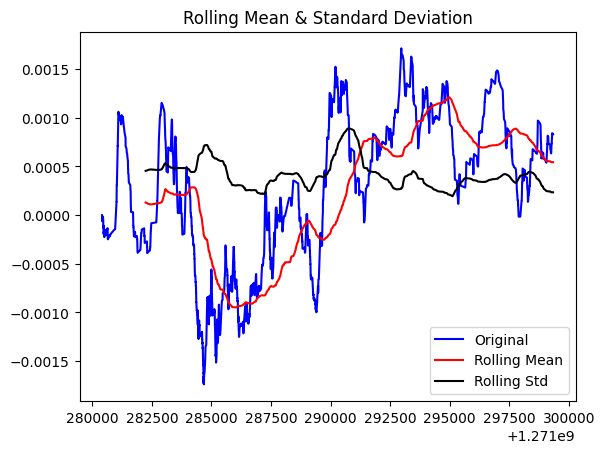

ADF Statistic: -2.4957969734640804
p-value: 0.11650031864051996
Critical Values:
	1%: -3.4310047528604803
	5%: -2.861829361784287
	10%: -2.5669240221402583


In [16]:
rolling_mean_exp_decay = df_log.ewm(halflife=1000, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

# ลบด้วยค่าก่อนหน้า

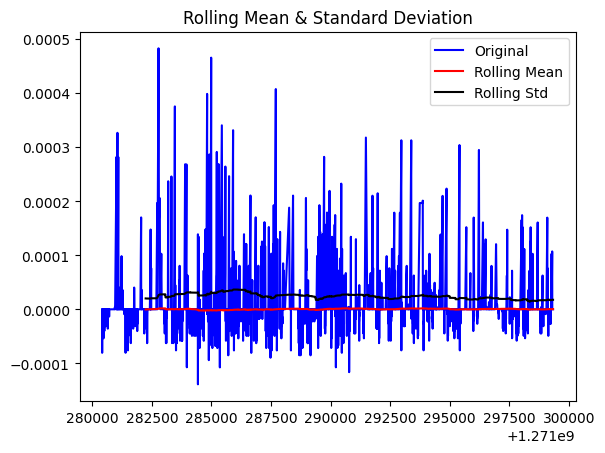

ADF Statistic: -27.3755995110716
p-value: 0.0
Critical Values:
	1%: -3.4310047528604803
	5%: -2.861829361784287
	10%: -2.5669240221402583


id
1271280414    2235.56
1271280415    2235.56
1271280416    2235.38
1271280417    2235.31
1271280418    2235.29
               ...   
1271299332    2240.77
1271299333    2240.77
1271299334    2240.77
1271299335    2240.77
1271299337    2240.77
Name: price, Length: 10000, dtype: float64

In [15]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

df.price

# Analysis for the ARIMA model

# STATEMODEL.API

In [17]:
# 1,1,2 ARIMA Model
df.price
model = sm.tsa.ARIMA(df.price, order=(1,1,2))
result = model.fit()
print(result.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                10000
Model:                 ARIMA(1, 1, 2)   Log Likelihood               14995.643
Date:                Sun, 07 Jan 2024   AIC                         -29983.286
Time:                        19:29:47   BIC                         -29954.445
Sample:                             0   HQIC                        -29973.523
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8513      0.018     48.006      0.000       0.817       0.886
ma.L1         -0.7242      0.018    -40.300      0.000      -0.759      -0.689
ma.L2         -0.0347      0.007     -4.754      0.0

In [18]:
df.price

id
1271280414    2235.56
1271280415    2235.56
1271280416    2235.38
1271280417    2235.31
1271280418    2235.29
               ...   
1271299332    2240.77
1271299333    2240.77
1271299334    2240.77
1271299335    2240.77
1271299337    2240.77
Name: price, Length: 10000, dtype: float64

In [19]:
# 1,1,1 ARIMA Model
model = sm.tsa.ARIMA(df.price, order=(1,1,1))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                10000
Model:                 ARIMA(1, 1, 1)   Log Likelihood               14991.593
Date:                Sun, 07 Jan 2024   AIC                         -29977.185
Time:                        19:32:30   BIC                         -29955.554
Sample:                             0   HQIC                        -29969.863
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8085      0.014     59.296      0.000       0.782       0.835
ma.L1         -0.6987      0.016    -44.109      0.000      -0.730      -0.668
sigma2         0.0029   5.94e-06    491.426      0.0

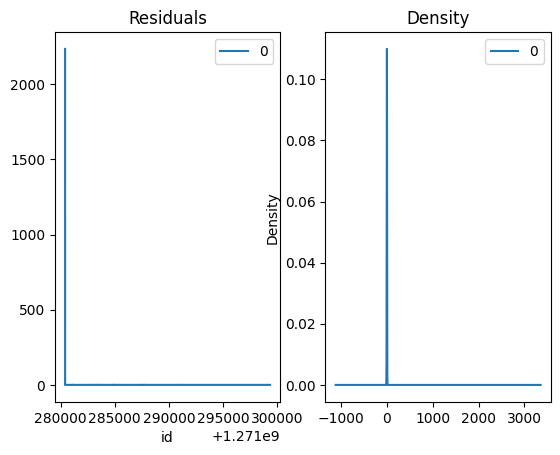

In [20]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# pmdarima

ใช้ pmdarima ซึ่งข้อดีของวิธีนี้คือ เราไม่ต้องมาเดา order ให้ใส่ order ตํ่าสุดสูงสุดไปแทน model จะเลือกให้เราเองอัตโนมัติ

In [24]:
# Fit auto_arima function to ETH price dataset
stepwise_fit = auto_arima(df['price'], start_p = 1, start_q = 1,
						max_p = 2, max_q = 2, m = 4,
						start_P = 0, seasonal = True,
						d = None, D = 1, trace = True,
						error_action ='ignore', # we don't want to know if an order does not work
						suppress_warnings = True, # we don't want convergence warnings
						stepwise = True)		 # set to stepwise


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=41.26 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=-12754.067, Time=0.99 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=-26481.167, Time=11.59 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=25.48 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=-12753.297, Time=0.50 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=-24134.408, Time=0.92 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=-27376.757, Time=25.63 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=44.31 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=41.88 sec
 ARIMA(0,0,0)(2,1,0)[4] intercept   : AIC=-13272.149, Time=5.99 sec
 ARIMA(2,0,0)(2,1,0)[4] intercept   : AIC=-27605.590, Time=32.46 sec
 ARIMA(2,0,0)(1,1,0)[4] intercept   : AIC=-26685.271, Time=19.83 sec
 ARIMA(2,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=50.39 sec
 ARIMA(2,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=37.30 sec
 ARIMA(2,0,1)(2,1,0)[4] intercept   :

In [25]:
# To print the summary
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                10000
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 4)   Log Likelihood               14763.740
Date:                           Sun, 07 Jan 2024   AIC                         -29513.481
Time:                                   20:03:18   BIC                         -29463.011
Sample:                                        0   HQIC                        -29496.397
                                         - 10000                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.059e-05   7.99e-05     -1.133      0.257      -0.000    6.61e-05
ar.L1          0.7183      0.048     15.073      0.000       0.625       0.812
ar.L2          0.2704      0.048      5.683      0.000       0.177       0.364
ma.L1          0.3601      0.047      7.688      0.000       0.268       0.452
ar.S.L4       -0.0097      0.010     -0.954      0.340      -0.030       0.010
ma.S.L4       -0.9376      0.006   -163.639      0.000      -0.949      -0.926
sigma2         0.0031   1.03e-05    296.318      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                  32.15   Jarque-Bera (JB):           4243091.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             7.92
Prob(H) (two-sided):                  0.00   Kurtosis:                       102.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
# Split data into train / test sets
train = df.iloc[:len(df)-600]
test = df.iloc[len(df)-600:] # set 10min x 60 second(600 second) for testing

# Fit a SARIMAX(2, 0, 1)x(1, 1, 1, 4) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['price'],
                order = (2, 0, 1),
                seasonal_order =(1, 1, 1, 4))

result = model.fit()
result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             price   No. Observations:                 9400
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 4)   Log Likelihood               13779.431
Date:                           Sun, 07 Jan 2024   AIC                         -27546.861
Time:                                   20:09:07   BIC                         -27503.973
Sample:                                        0   HQIC                        -27532.299
                                          - 9400                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0040      0.004      1.028      0.304      -0.004       0.012
ar.L2          0.9960      0.004    256.949      0.000       0.988       1.004
ma.L1          0.9978      0.003    303.014      0.000       0.991       1.004
ar.S.L4        0.0551      0.009      6.224      0.000       0.038       0.072
ma.S.L4       -0.9981      0.001   -856.849      0.000      -1.000      -0.996
sigma2         0.0031   6.54e-06    476.696      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                 179.60   Jarque-Bera (JB):           4100947.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             8.12
Prob(H) (two-sided):                  0.00   Kurtosis:                       104.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='id'>

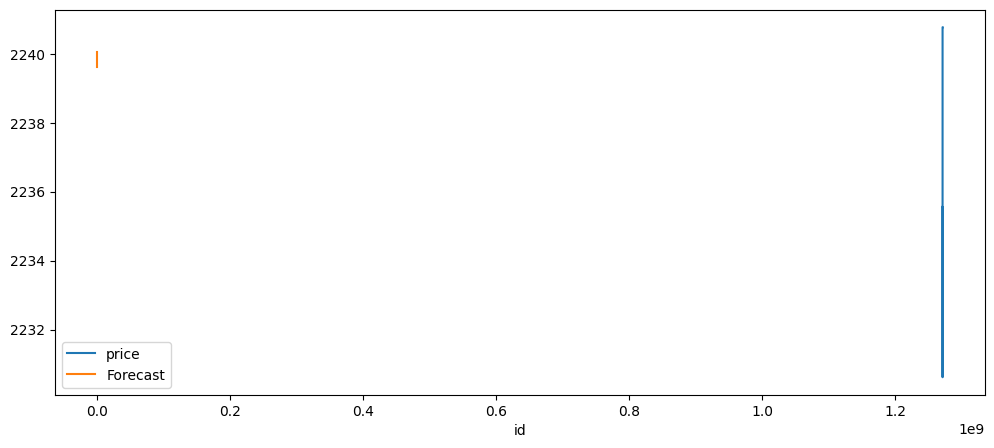

In [27]:
# Forecast for the next 600 period (600 second)
forecast = result.predict(start = len(df),
                          end = (len(df)-1) + 1 * 600,
                          typ = 'levels').rename('Forecast')

# Plot the forecast values
df['price'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

In [28]:
print(forecast)

10000    2239.629956
10001    2239.629904
10002    2239.633670
10003    2239.632326
10004    2239.632822
            ...     
10595    2240.056012
10596    2240.056583
10597    2240.056452
10598    2240.060294
10599    2240.058873
Name: Forecast, Length: 600, dtype: float64


In [29]:
forecast.to_csv('test600.csv')